In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [3]:
content_path = 'images/srinjay.jpeg'
style_path = 'images/starry_night.jpg'

content = Image.open(content_path)
style = Image.open(style_path)

height= 512
width = 512

content = content.resize((height,width))
style = style.resize((height,width))


In [4]:
content_array = np.asarray(content,dtype='float32')
style_array = np.asarray(style,dtype='float32')

content_array = np.expand_dims(content_array,axis=0)
style_array = np.expand_dims(style_array,axis=0)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [5]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
output_image = backend.placeholder((1,height, width, 3))

In [6]:
input_tensor = backend.concatenate([content_image,style_image,output_image], axis=0)

In [7]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)

In [8]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

loss = backend.variable(0.)

In [9]:
def content_loss(content, output):
    return backend.sum(backend.square(output - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
output_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,output_features)

In [10]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, output):
    S = gram_matrix(style)
    O = gram_matrix(output)
    channels = 3
    size = height * width
    
    return backend.sum(backend.square(S - O)) / (4. * (channels ** 2) * (size ** 2))

In [11]:
features = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']
for layer_name in features:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    output_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, output_features)
    loss += (style_weight/ len(features)) * sl

In [12]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(output_image)

In [13]:
grads = backend.gradients(loss, output_image)

In [14]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([output_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


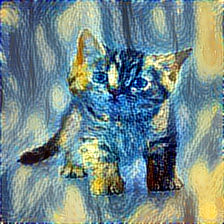

In [15]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

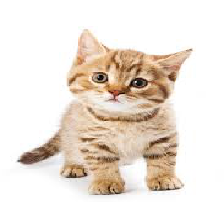

In [16]:
content

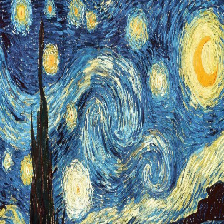

In [17]:
style

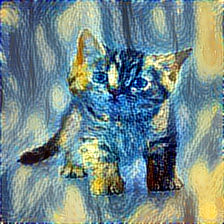

In [18]:
Image.fromarray(x)